In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import safetensors
from safetensors import safe_open
import torch
from pathlib import Path
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Baseline

In [14]:
feature_path = "/data/lux70/data/pfam/features/all.pt"
with safe_open(feature_path, "pt") as f:
    features = f.get_tensor('features')

print(features.shape)

NUM_TO_EVAL = 512
idxs = np.arange(NUM_TO_EVAL * 2)
np.random.shuffle(idxs)

idxs1 = idxs[:NUM_TO_EVAL]
idxs2 = idxs[NUM_TO_EVAL:]

gt_x1 = features[idxs1].numpy()
gt_x2 = features[idxs2].numpy()

torch.Size([11886, 32])


In [15]:
from plaid.evaluation import parmar_kid, parmar_fid, ConditionalFID

In [16]:
uncond_gt_fid = parmar_fid(gt_x1, gt_x2)
print(uncond_gt_fid)

0.004427324210236727


In [17]:
parmar_kid(gt_x1, gt_x2)

-3.0023683074134057e-05

### Unconditional to Random

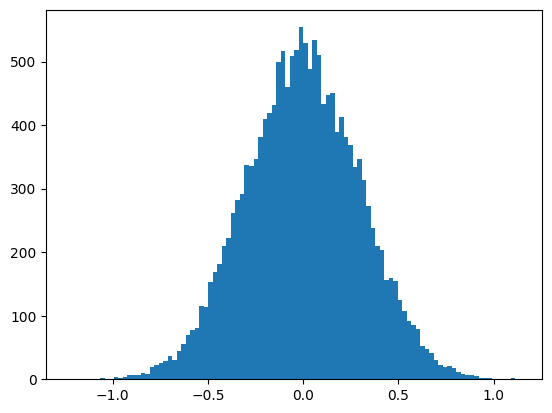

In [18]:
# from scipy.stats import beta

# # Beta distribution parameters can be tweaked for a Gaussian-like shape
# alpha, beta_param = 8, 8
# samples = beta(alpha, beta_param).rvs(1000)

# # Rescale to [-1, 1]
# bounded_samples = 2 * samples - 0.9
# print(bounded_samples.shape)
# _ = plt.hist(bounded_samples.flatten(),bins=100)


random = np.random.normal(0, 0.3, (512, 32))
_ = plt.hist(random.flatten(), bins=100)

In [19]:
random_fid = parmar_fid(random, gt_x1)
print(random_fid)

3.64562124110458


In [20]:
parmar_fid(random, gt_x2)

3.6613143722900707

# Unconditional generation performance

In [21]:
with np.load("/data/lux70/plaid/artifacts/samples/5j007z42/f2219_o3617/240907_0658/latent.npz", allow_pickle=True) as f:
    uncond_gen = f['samples']

print(uncond_gen.shape)
uncond_gen = uncond_gen.astype(np.float32)

(1024, 128, 32)


In [22]:
idxs = np.arange(len(uncond_gen))
np.random.shuffle(idxs)
uncond_gen = uncond_gen[idxs[:NUM_TO_EVAL]]
uncond_gen = uncond_gen.mean(axis=1)
print(uncond_gen.shape)

(512, 32)


In [23]:
uncond_gen_fid = parmar_fid(gt_x1, uncond_gen)
print(uncond_gen_fid)

# just to double check, use the other chunk too
print(parmar_fid(gt_x2, uncond_gen))

0.07637256839755446
0.08355992729511436


In [24]:
print(parmar_kid(gt_x1, uncond_gen))
print(parmar_kid(gt_x2, uncond_gen))

0.002485317666003457
0.002933099899739986


# Amass Conditional FID

In [25]:
# from cheap.pretrained import CHEAP_pfam_shorten_2_dim_32
# cheap_pipeline = CHEAP_pfam_shorten_2_dim_32()

In [26]:
from plaid.evaluation import ConditionalFID
from pathlib import Path
import glob
import numpy as np
import torch
import os

samples_dir = Path("/data/lux70/plaid/artifacts/samples/dpm2m/5j007z42")

In [27]:
# def cond_code_to_idx(cond_code: str):
#     vals = cond_code.split("_")
#     return int(vals[0][1:]), int(vals[1][1:])


# condgen_to_true = {}
# uncond_to_true = {}

# batch_size = 128


# for i, cond_code in enumerate(os.listdir(samples_dir)):
#     function_idx, organism_idx = cond_code_to_idx(cond_code)
#     # timestamps = glob.glob(str(samples_dir / cond_code / "*.npz"))
#     timestamps = os.listdir(samples_dir / cond_code)
    
#     if len(timestamps) > 0:
#         try:
#             timestamp = timestamps[-1]
#             fpath = samples_dir / cond_code / timestamp / "latent.npz"
#             print(fpath)
    
#             cond_fid = ConditionalFID(
#                 function_idx=function_idx,
#                 organism_idx=organism_idx,
#                 cheap_pipeline=cheap_pipeline,
#                 batch_size=batch_size,
#                 max_seq_len=256,
#                 max_eval_samples=512
#             )
            
#             with np.load(fpath, allow_pickle=True) as f:
#                 x = f['samples'].astype(np.float32)
    
#             feat = x[:, -1, :, :] # take last timestep only
#             feat = feat.mean(axis=1)
#             res = cond_fid.run(feat)
#             print(cond_code, "Generated <-> GT FID:", res)
    
#             condgen_to_true[cond_code] = res
    
#             # also try what happens if you do ground truth unconditional to conditional
#             res = parmar_fid(feat, gt_x1)
#             uncond_to_true[cond_code] = res
#             print(cond_code, "Random Real <-> GT FID:", res)
#         except Exception as e:
#             print(e)
#             continue
            
#     else:
#         pass

# Plot

In [19]:
# # turn into dataframe
# df1 = pd.DataFrame(list(condgen_to_true.items()), columns=['Key', 'condgen_to_true'])
# df2 = pd.DataFrame(list(uncond_to_true.items()), columns=['Key', 'uncond_to_true'])
# combined_df = pd.merge(df1, df2, on='Key')
# combined_df["GO_idx"] = combined_df['Key'].map(lambda x: cond_code_to_idx(x)[0])
# combined_df["organism_index"] = combined_df['Key'].map(lambda x: cond_code_to_idx(x)[1])

# # attach GO metadata
# go_df = pd.read_csv("/data/lux70/data/pfam/go_index.csv")
# combined_df = combined_df.merge(go_df)
# combined_df = combined_df.sort_values(by="count")
# combined_df['delta'] = combined_df.condgen_to_true - combined_df.uncond_to_true

In [20]:
# from matplotlib import cm
# from matplotlib.colors import Normalize

# values = combined_df['delta']
# norm = Normalize(vmin=min(values), vmax=max(values))

# colormap = cm.viridis  # You can replace 'viridis' with any other matplotlib colormap
# colors = colormap(norm(values))


In [21]:
combined_df

,Key,condgen_to_true,uncond_to_true,GO_idx,organism_index,Unnamed: 0,GO_term,pfam_id,GO_id,GO_level,count,delta
101,f1049_o3617,8.628482,9.047394,1049,3617,1127,mannonate dehydratase activity,PF03786,GO:0008927,function,1,-0.418912
123,f1933_o3617,8.184402,8.946230,1933,3617,395,alkaloid metabolic process,PF11991,GO:0009820,process,1,-0.761828
176,f467_o3617,7.121013,8.345885,467,3617,365,actin monomer binding,PF01290,GO:0003785,function,1,-1.224872
177,f1523_o3617,7.010859,8.245099,1523,3617,440,apoplast,PF06955,GO:0048046,component,1,-1.234240
117,f1685_o3617,9.625937,8.825531,1685,3617,1919,shikimate 3-dehydrogenase (NADP+) activity,PF08501,GO:0004764,function,1,0.800407
...,...,...,...,...,...,...,...,...,...,...,...,...
320,f411_o3617,7.719725,8.860197,411,3617,1369,nucleus,PF01125,GO:0005634,component,149,-1.140472
256,f2_o3617,8.942130,9.143143,2,3617,52,ATP binding,PF00006,GO:0005524,function,178,-0.201013
33,f86_o3617,9.169778,8.952341,86,3617,1771,regulation of DNA-templated transcription,PF00196,GO:0006355,process,182,0.217437
77,f19_o3617,8.624237,8.252051,19,3617,99,DNA binding,PF00046,GO:0003677,function,320,0.372186


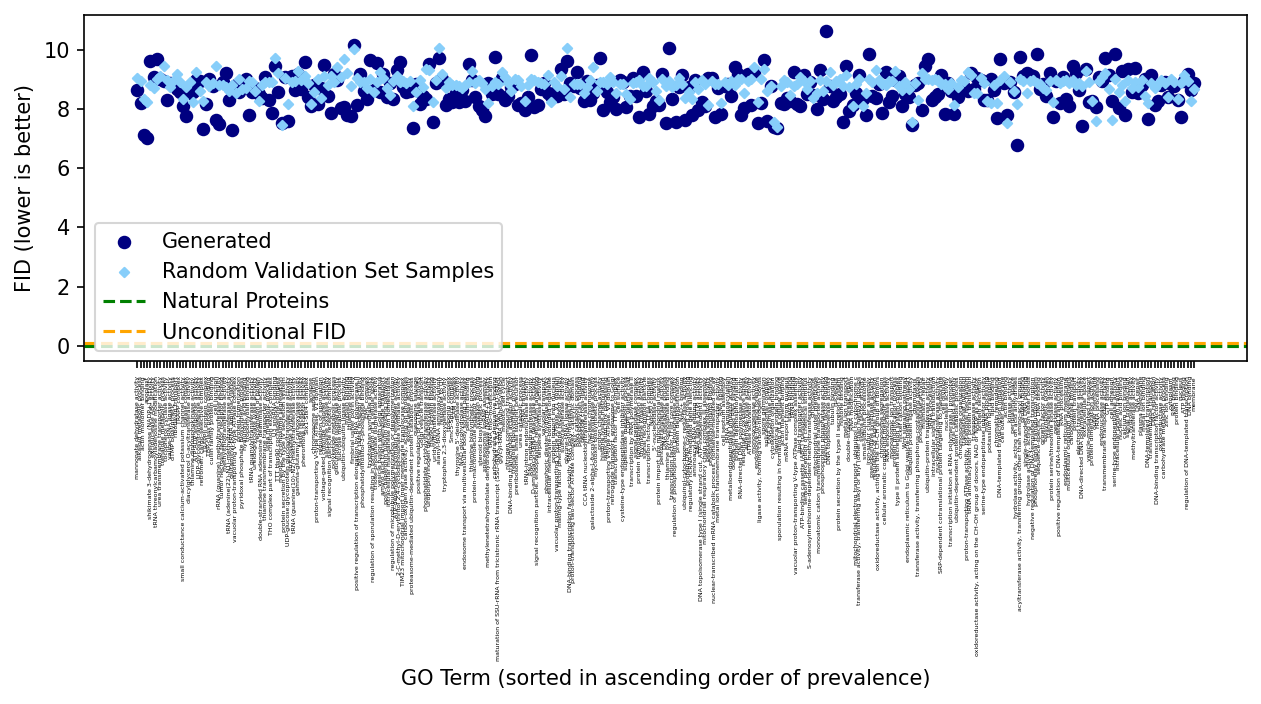

In [36]:
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(10,3))
ax.scatter(np.arange(len(combined_df)), combined_df['condgen_to_true'].values, label="Generated", s=30, c="navy")
# ax.scatter(np.arange(len(combined_df)), combined_df['uncond_to_true'].values, label="Random Validation Set Samples",s=15, c=colors, marker="D")
ax.scatter(np.arange(len(combined_df)), combined_df['uncond_to_true'].values, label="Random Validation Set Samples",s=10, c="lightskyblue", marker="D")
ax.set_xticks(ticks=np.arange(len(combined_df)), labels=combined_df.GO_term.values, rotation=90,fontsize=3)

ax.axhline(y=uncond_gt_fid, color='green', linestyle='--', label="Natural Proteins")
ax.axhline(y=uncond_gen_fid, color='orange', linestyle='--', label="Unconditional FID")


### TODO: modify upper bound on y lim as needed
### TODO: wrap text?

ax.set_xlabel("GO Term (sorted in ascending order of prevalence)")
ax.set_ylabel("FID (lower is better)")

plt.legend()

In [23]:
combined_df.sort_values(by="delta")

,Key,condgen_to_true,uncond_to_true,GO_idx,organism_index,Unnamed: 0,GO_term,pfam_id,GO_id,GO_level,count,delta
101,f1049_o3617,8.628482,9.047394,1049,3617,1127,mannonate dehydratase activity,PF03786,GO:0008927,function,1,-0.418912
123,f1933_o3617,8.184402,8.946230,1933,3617,395,alkaloid metabolic process,PF11991,GO:0009820,process,1,-0.761828
176,f467_o3617,7.121013,8.345885,467,3617,365,actin monomer binding,PF01290,GO:0003785,function,1,-1.224872
177,f1523_o3617,7.010859,8.245099,1523,3617,440,apoplast,PF06955,GO:0048046,component,1,-1.234240
117,f1685_o3617,9.625937,8.825531,1685,3617,1919,shikimate 3-dehydrogenase (NADP+) activity,PF08501,GO:0004764,function,1,0.800407


In [34]:
combined_df.shape

(323, 12)

In [35]:
# combined_df.to_csv("~/cond_fid_dpm2m_t10.csv", sep=",")

# Across Sampling Timesteps

In [25]:
latent_path = Path("/data/lux70/plaid/artifacts/samples/dpm2m/5j007z42/f800_o3617/240915_1016/latent.npz")

with np.load(latent_path) as f:
    x = f['samples']

In [26]:
x.shape

(512, 11, 76, 32)

In [27]:
gt_x1.shape

(512, 32)

In [28]:
from tqdm.notebook import trange

fids = []

for i in trange(x.shape[1]): # across timesteps
    lat = x[:, i, :, :]
    fid = parmar_fid(gt_x1, lat.mean(axis=1))
    fids.append(fid)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Text(0, 0.5, 'FID')

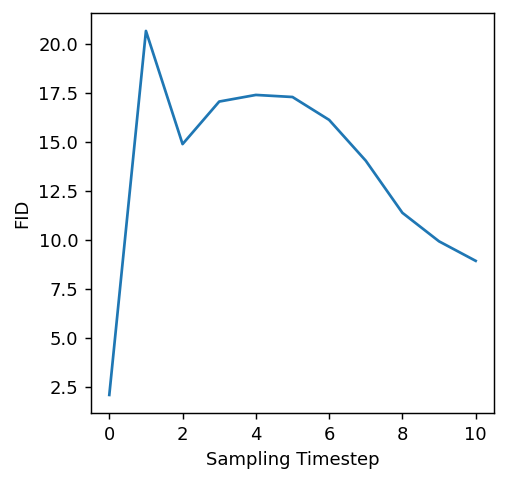

In [29]:
from tqdm.notebook import trange

fids = []

for i in trange(x.shape[1]): # across timesteps
    lat = x[:, i, :, :]
    fid = parmar_fid(gt_x1, lat.mean(axis=1))
    fids.append(fid)

fig,ax = plt.subplots(1,1,dpi=130, figsize=(4,4))
ax.plot(fids)
ax.set_xlabel("Sampling Timestep")
ax.set_ylabel("FID")

# Play around with DPM++

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import hydra
from omegaconf import OmegaConf
cfg = OmegaConf.load("/homefs/home/lux70/code/plaid/configs/pipeline/dpm_sample_latent.yaml")

In [3]:
cfg

{'model_id': '5j007z42', 'model_ckpt_dir': '/data/lux70/plaid/checkpoints/plaid-compositional', 'organism_idx': 3617, 'function_idx': 2219, 'cond_scale': 10.0, 'num_samples': 1024, 'beta_scheduler_name': None, 'beta_scheduler_start': None, 'beta_scheduler_end': None, 'beta_scheduler_tau': None, 'sampling_timesteps': 50, 'batch_size': -1, 'return_all_timesteps': True, 'output_root_dir': '/data/lux70/plaid/artifacts/samples/dpm2m', 'length': 32, 't_start': None, 't_end': None, 'order': 2, 'skip_type': 'time_uniform', 'method': 'multistep', 'lower_order_final': True, 'denoise_to_zero': False, 'solver_type': 'dpmsolver', 'atol': 0.0078, 'rtol': 0.05}

In [4]:
from plaid.pipeline import DPMSolverSampleLatent

cfg['sampling_timesteps'] = 10
solver = DPMSolverSampleLatent(**cfg)

/homefs/home/lux70/micromamba/envs/plaid-train/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/homefs/home/lux70/micromamba/envs/plaid-train/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
/homefs/home/lux70/code/plaid/src/plaid/pipeline/_sample.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execut

Sampling timesteps: 10


In [6]:
x = solver.sample()

Starting DPM sampling...
Init the first 1 order values by lower order multistep DPM-Solver.


Order 2 to step 10:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Text(0, 0.5, 'FID')

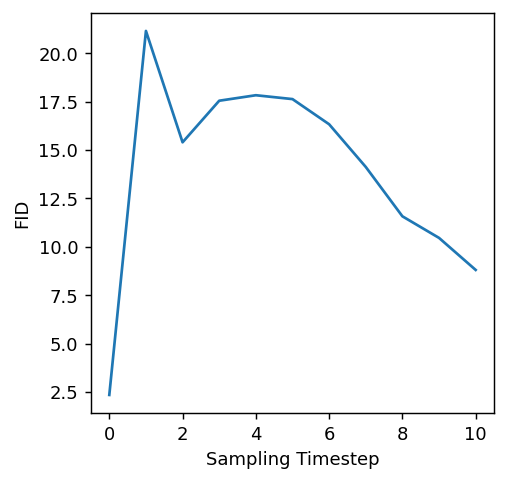

In [28]:
from tqdm.notebook import trange
from plaid.evaluation import parmar_fid

fids = []
# x = x.cpu().numpy()

for i in trange(x.shape[1]): # across timesteps
    lat = x[:, i, :, :]
    fid = parmar_fid(gt_x1, lat.mean(axis=1))
    fids.append(fid)

fig,ax = plt.subplots(1,1,dpi=130, figsize=(4,4))
ax.plot(fids)
ax.set_xlabel("Sampling Timestep")
ax.set_ylabel("FID")

In [42]:
# cfg['sampling_timesteps'] =  30
# solver = DPMSolverSampleLatent(**cfg)

# import time

# start = time.time()
# x = solver.sample()
# end = time.time()
# print(f"Sampling took {(end - start)} seconds")

# fids = []

# try:
#     x = x.cpu().numpy()
# except:
#     pass

# for i in trange(x.shape[1]): # across timesteps
#     lat = x[:, i, :, :]
#     fid = parmar_fid(gt_x1, lat.mean(axis=1))
#     fids.append(fid)

# print(fids[-1])

# fig,ax = plt.subplots(1,1,dpi=130, figsize=(4,4))
# ax.plot(fids)
# ax.set_xlabel("Sampling Timestep")
# ax.set_ylabel("FID")

In [43]:
# cfg['sampling_timesteps'] = 20
# cfg['solver_type'] = "dpmsolver"
# cfg['order'] = 3
# cfg['method'] = "singlestep"

# solver = DPMSolverSampleLatent(**cfg)

# import time

# start = time.time()
# x = solver.sample()
# end = time.time()
# print(f"Sampling took {(end - start)} seconds")

# fids = []

# try:
#     x = x.cpu().numpy()
# except:
#     pass

# for i in trange(x.shape[1]): # across timesteps
#     lat = x[:, i, :, :]
#     fid = parmar_fid(gt_x1, lat.mean(axis=1))
#     fids.append(fid)

# print(fids[-1])

# fig,ax = plt.subplots(1,1,dpi=130, figsize=(4,4))
# ax.plot(fids)
# ax.set_xlabel("Sampling Timestep")
# ax.set_ylabel("FID")

In [44]:
from plaid.diffusion.additional_samplers import *

In [46]:
sigma_min = 1e-2
sigma_max = 160
n = 100
sigmas = get_sigmas_karras(n, sigma_min, sigma_max, rho=7., device='cpu')

In [47]:
discrete_schedule = DiscreteSchedule(sigmas, quantize=True)

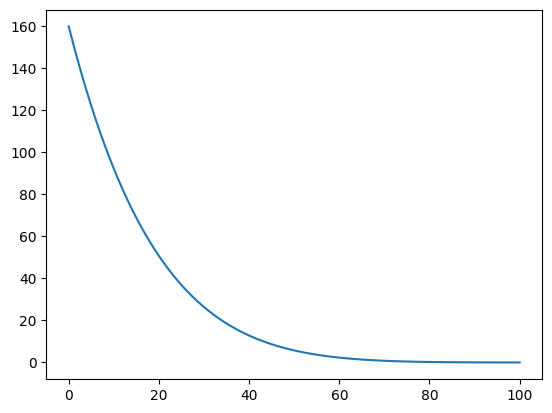

In [48]:
plt.plot(sigmas)

In [49]:
T = discrete_schedule.sigma_to_t(sigmas)

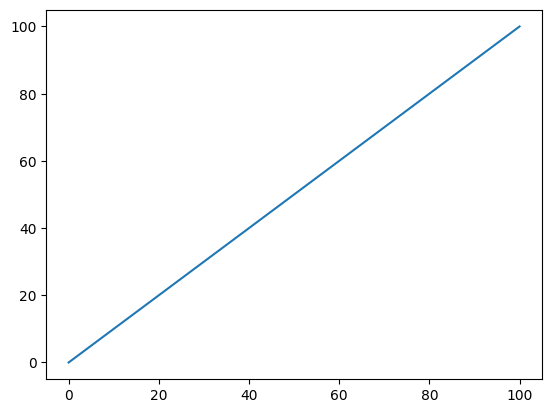

In [51]:
plt.plot(T)

In [53]:
from plaid.datasets import NUM_FUNCTION_CLASSES, NUM_ORGANISM_CLASSES

extra_args = {
    "function_idx": NUM_FUNCTION_CLASSES,
    "organism_idx": NUM_ORGANISM_CLASSES,
    "mask": None,
    "cond_scale": 1.,
    "rescaled_phi": 0.7,
}

In [ ]:
x = sample_dpmpp_2m(model, x, sigmas, extra_args=None, callback=None, disable=None):